# SNiFi: Random Forest Model Prototyping with SMOTE

---

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, f1_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from statistics import mean
from tqdm import tqdm
import joblib

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from ml.data_handling import DataLoader, Preprocessor

RANDOM_STATE = 42

ML_DIR = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATASET_PATH = os.path.join(ML_DIR, 'data', 'preprocessed', 'csv', '0.066percent_original_labels.csv')

MODEL_VERSION = 'v1.0.0'
MODEL_PATH = os.path.join(ML_DIR, 'models', f'RF_model_{MODEL_VERSION}_SMOTE.pkl')
IANA_MAP = { 
    "0": "HOPOPT", "1": "ICMP", "2": "IGMP", "3": "GGP", "4": "IPv4", "5": "ST", 
    "6": "TCP", "7": "CBT", "8": "EGP", "9": "IGP", "10": "BBN-RCC-MON", "11": "NVP-II", 
    "12": "PUP", "13": "ARGUS (deprecated)", "14": "EMCON", "15": "XNET", "16": "CHAOS", 
    "17": "UDP", "18": "MUX", "19": "DCN-MEAS", "20": "HMP", "21": "PRM", "22": "XNS-IDP", 
    "23": "TRUNK-1", "24": "TRUNK-2", "25": "LEAF-1", "26": "LEAF-2", "27": "RDP", 
    "28": "IRTP", "29": "ISO-TP4", "30": "NETBLT", "31": "MFE-NSP", "32": "MERIT-INP", 
    "33": "DCCP", "34": "3PC", "35": "IDPR", "36": "XTP", "37": "DDP", "38": "IDPR-CMTP", 
    "39": "TP++", "40": "IL", "41": "IPv6", "42": "SDRP", "43": "IPv6-Route", 
    "44": "IPv6-Frag", "45": "IDRP", "46": "RSVP", "47": "GRE", "48": "DSR", "49": "BNA", 
    "50": "ESP", "51": "AH", "52": "I-NLSP", "53": "SWIPE (deprecated)", "54": "NARP", 
    "55": "MOBILE", "56": "TLSP", "57": "SKIP", "58": "IPv6-ICMP", "59": "IPv6-NoNxt", 
    "60": "IPv6-Opts", "62": "CFTP", "64": "SAT-EXPAK", "65": "KRYPTOLAN", "66": "RVD", 
    "67": "IPPC", "69": "SAT-MON", "70": "VISA", "71": "IPCV", "72": "CPNX", "73": "CPHB", 
    "74": "WSN", "75": "PVP", "76": "BR-SAT-MON", "77": "SUN-ND", "78": "WB-MON", 
    "79": "WB-EXPAK", "80": "ISO-IP", "81": "VMTP", "82": "SECURE-VMTP", "83": "VINES", 
    "84": "IPTM", "85": "NSFNET-IGP", "86": "DGP", "87": "TCF", "88": "EIGRP", 
    "89": "OSPFIGP", "90": "Sprite-RPC", "91": "LARP", "92": "MTP", "93": "AX.25", 
    "94": "IPIP", "95": "MICP (deprecated)","96": "SCC-SP", "97": "ETHERIP", "98": "ENCAP", 
    "100": "GMTP", "101": "IFMP", "102": "PNNI", "103": "PIM", "104": "ARIS", "105": "SCPS", 
    "106": "QNX", "107": "A/N", "108": "IPComp", "109": "SNP", "110": "Compaq-Peer", 
    "111": "IPX-in-IP", "112": "VRRP", "113": "PGM", "114": "", "115": "L2TP", "116": "DDX",  
    "117": "IATP", "118": "STP", "119": "SRP", "120": "UTI", "121": "SMP", 
    "122": "SM (deprecated)", "123": "PTP","124": "ISIS over IPv4", "125": "FIRE", 
    "126": "CRTP", "127": "CRUDP", "128": "SSCOPMCE", "129": "IPLT", "130": "SPS", 
    "131": "PIPE", "132": "SCTP",  "133": "FC", "134": "RSVP-E2E-IGNORE", 
    "135": "Mobility Header", "136": "UDPLite", "137": "MPLS-in-IP", "138": "manet", 
    "139": "HIP", "140": "Shim6", "141": "WESP", "142": "ROHC", "143": "Ethernet", 
    "144": "AGGFRAG", "145": "NSH"
}
IANA_REVERSE_MAP = {v: k for k, v in IANA_MAP.items()}
X_columns = ['flow_duration', 'header_length', 'protocol_type', 'duration', 
             'rate', 'srate', 'drate', 'fin_flag_number', 'syn_flag_number', 
             'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 
             'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 
             'fin_count', 'urg_count', 'rst_count', 'http', 'https', 'dns', 
             'telnet', 'smtp', 'ssh', 'irc', 'tcp', 'udp', 'dhcp', 'arp', 'icmp', 
             'ipv', 'llc', 'tot_sum', 'min', 'max', 'avg', 'std', 'tot_size', 
             'iat', 'number', 'magnitue', 'radius', 'covariance', 'variance', 
             'weight']
y_column = 'label'

class_mapping = {
    'DDoS-RSTFINFlood': 'Attack',
    'DDoS-PSHACK_Flood': 'Attack',
    'DDoS-SYN_Flood': 'Attack',
    'DDoS-UDP_Flood': 'Attack',
    'DDoS-TCP_Flood': 'Attack',
    'DDoS-ICMP_Flood': 'Attack',
    'DDoS-SynonymousIP_Flood': 'Attack',
    'DDoS-ACK_Fragmentation': 'Attack',
    'DDoS-UDP_Fragmentation': 'Attack',
    'DDoS-ICMP_Fragmentation': 'Attack',
    'DDoS-SlowLoris': 'Attack',
    'DDoS-HTTP_Flood': 'Attack',
    'DoS-UDP_Flood': 'Attack',
    'DoS-SYN_Flood': 'Attack',
    'DoS-TCP_Flood': 'Attack',
    'DoS-HTTP_Flood': 'Attack',
    'Mirai-greeth_flood': 'Attack',
    'Mirai-greip_flood': 'Attack',
    'Mirai-udpplain': 'Attack',
    'Recon-PingSweep': 'Attack',
    'Recon-OSScan': 'Attack',
    'Recon-PortScan': 'Attack',
    'VulnerabilityScan': 'Attack',
    'Recon-HostDiscovery': 'Attack',
    'DNS_Spoofing': 'Attack',
    'MITM-ArpSpoofing': 'Attack',
    'BenignTraffic': 'Benign',
    'BrowserHijacking': 'Attack',
    'Backdoor_Malware': 'Attack',
    'XSS': 'Attack',
    'Uploading_Attack': 'Attack',
    'SqlInjection': 'Attack',
    'CommandInjection': 'Attack',
    'DictionaryBruteForce': 'Attack'
}

In [2]:
data_loader = DataLoader(os.path.dirname(DATASET_PATH))
df = data_loader.load_data([os.path.basename(DATASET_PATH)])
df['protocol_type'] = df['protocol_type'].map(IANA_REVERSE_MAP).astype(float)
print(f"\nNumber of rows and columns: {df.shape}\n")
print(f"Column names: {df.columns.tolist()}\n")

100%|██████████| 1/1 [00:07<00:00,  7.75s/it]



Number of rows and columns: (3078435, 47)

Column names: ['flow_duration', 'header_length', 'protocol_type', 'duration', 'rate', 'srate', 'drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'http', 'https', 'dns', 'telnet', 'smtp', 'ssh', 'irc', 'tcp', 'udp', 'dhcp', 'arp', 'icmp', 'ipv', 'llc', 'tot_sum', 'min', 'max', 'avg', 'std', 'tot_size', 'iat', 'number', 'magnitue', 'radius', 'covariance', 'variance', 'weight', 'label']



In [3]:
df

,flow_duration,header_length,protocol_type,duration,rate,srate,drate,fin_flag_number,syn_flag_number,rst_flag_number,...,std,tot_size,iat,number,magnitue,radius,covariance,variance,weight,label
0,0.000000,54.00,6.0,64.0,4.821845,4.821845,0.0,False,False,False,...,0.000000,54.00,8.333186e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-PSHACK_Flood
1,0.000000,54.00,6.0,64.0,21.433465,21.433465,0.0,True,False,True,...,0.000000,54.00,8.334380e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-RSTFINFlood
2,0.020261,15325.00,17.0,64.0,15186.696639,15186.696639,0.0,False,False,False,...,0.000000,50.00,8.310668e+07,9.5,10.000000,0.000000,0.000000,0.00,141.55,DDoS-UDP_Flood
3,0.000000,54.00,6.0,64.0,1.001085,1.001085,0.0,False,False,False,...,0.000000,54.00,8.331391e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-PSHACK_Flood
4,0.000000,54.00,6.0,64.0,20.351511,20.351511,0.0,False,False,False,...,0.000000,54.00,8.306396e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-TCP_Flood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3078430,0.000000,54.00,6.0,64.0,0.000000,0.000000,0.0,False,True,False,...,0.000000,54.00,8.336141e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-SynonymousIP_Flood
3078431,7.689626,231.24,6.0,64.0,0.552429,0.552429,0.0,False,False,True,...,0.000000,54.00,8.297240e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DoS-SYN_Flood
3078432,0.050077,58.06,6.0,64.0,1.265144,1.265144,0.0,False,True,False,...,10.484298,55.76,8.336231e+07,9.5,10.776277,14.840357,620.739807,0.19,141.55,DDoS-SynonymousIP_Flood
3078433,0.000000,54.00,6.0,64.0,20.076269,20.076269,0.0,False,False,False,...,0.000000,54.00,8.306830e+07,9.5,10.392305,0.000000,0.000000,0.00,141.55,DDoS-TCP_Flood


In [4]:
preprocessor = Preprocessor(X_columns, y_column, class_mapping)
preprocessor.fit_scaler(df)
df = preprocessor.transform_data(df)

In [5]:
print(df.isnull().sum())
df.dropna(inplace=True)

flow_duration      0
header_length      0
protocol_type      0
duration           0
rate               0
srate              0
drate              0
fin_flag_number    0
syn_flag_number    0
rst_flag_number    0
psh_flag_number    0
ack_flag_number    0
ece_flag_number    0
cwr_flag_number    0
ack_count          0
syn_count          0
fin_count          0
urg_count          0
rst_count          0
http               0
https              0
dns                0
telnet             0
smtp               0
ssh                0
irc                0
tcp                0
udp                0
dhcp               0
arp                0
icmp               0
ipv                0
llc                0
tot_sum            0
min                0
max                0
avg                0
std                0
tot_size           0
iat                0
number             0
magnitue           0
radius             0
covariance         0
variance           0
weight             0
label              0
dtype: int64


In [7]:
class_counts = df[y_column].value_counts()
print("Class distribution before balancing:")
print(class_counts)

X = df[X_columns]
y = df[y_column]
label_mapping = {'Benign': 0, 'Attack': 1}
y = y.map(label_mapping)

Class distribution before balancing:
label
Attack    3006039
Benign      72396
Name: count, dtype: int64


In [8]:
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

In [9]:
class_counts_res = pd.Series(y_resampled).value_counts()
print("Class distribution after balancing with SMOTE:")
print(class_counts_res)

Class distribution after balancing with SMOTE:
label
1    3006039
0    3006039
Name: count, dtype: int64


In [10]:
SMOTE_SRF = RandomForestClassifier(n_estimators=150, random_state=0, n_jobs=-1)

In [12]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
scoring = ('f1', 'recall', 'precision')

In [17]:
scores = {'test_f1': [], 'test_recall': [], 'test_precision': []}
for train_index, test_index in tqdm(cv.split(X_resampled, y_resampled), total=cv.get_n_splits()):
    X_train, X_test = X_resampled.iloc[train_index], X_resampled.iloc[test_index]
    y_train, y_test = y_resampled.iloc[train_index], y_resampled.iloc[test_index]
    
    SMOTE_SRF.fit(X_train, y_train)
    y_pred = SMOTE_SRF.predict(X_test)
    
    scores['test_f1'].append(f1_score(y_test, y_pred))
    scores['test_recall'].append(recall_score(y_test, y_pred))
    scores['test_precision'].append(precision_score(y_test, y_pred))

print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))

100%|██████████| 10/10 [1:20:40<00:00, 484.05s/it]

Mean f1: 0.998
Mean recall: 0.997
Mean precision: 1.000


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=RANDOM_STATE)

In [19]:
SMOTE_SRF.fit(X_train, y_train)

RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=0)

In [20]:
y_pred = SMOTE_SRF.predict(X_test)

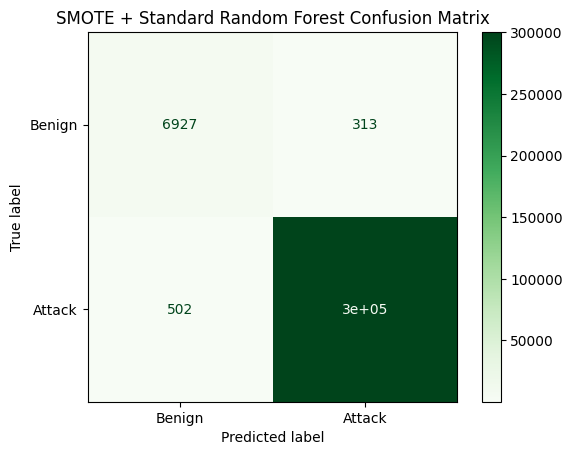

In [21]:
ConfusionMatrixDisplay.from_estimator(SMOTE_SRF, X_test, y_test, display_labels=['Benign', 'Attack'], cmap='Greens')
plt.title('SMOTE + Standard Random Forest Confusion Matrix')
plt.show()

In [22]:
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Benign', 'Attack']))

Classification Report:
               precision    recall  f1-score   support

      Benign       0.93      0.96      0.94      7240
      Attack       1.00      1.00      1.00    300604

    accuracy                           1.00    307844
   macro avg       0.97      0.98      0.97    307844
weighted avg       1.00      1.00      1.00    307844



In [24]:
joblib.dump(SMOTE_SRF, MODEL_PATH)
print(f"Model saved to {MODEL_PATH}")

Model saved to /home/kap/projects/SNiFi/ml/models/RF_model_v1.0.0_SMOTE.pkl
